## Here, we used new training data that has randomized dispersions and phases to try and predict the dispersion as well as the phase.


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

## Made new training data with E_0 fixed. 

In [2]:
#Load the training data

subset = 5 #every 10 mV
start = 50 # for starting at -300mV

peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
energy_names2 = energy_names[start::subset]
energy_names3 = energy_names[start::1]

col_names2 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names + locs_names + width_names + prom_names
col_names2a = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names[1:] + locs_names + width_names + prom_names[1:]

col_names1 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names

#col_names_both = col_names2 + energy_names2
col_names_both = col_names2a + energy_names2
col_names_a = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names3


data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData071218_v10_E0fixed_specPoints.csv', header = None, names = col_names1)
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData071218_v10_E0fixed_peakinfo.csv', header = None, names = col_names2)
save_data = True

data = data2.join(data1.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1), how = 'left')
data = data[col_names_both]

data1a = data1[col_names_a]
data2a = data2[col_names2a]

X1 = data1a.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y1 = data1a[['deltaI', 'deltaR', 'mstar', 'alpha']]

X2 = data2a.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y2 = data2a[['deltaI', 'deltaR', 'mstar', 'alpha']]

X = data.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y = data[['deltaI', 'deltaR', 'mstar', 'alpha']]

ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

data1.head()

,deltaI,deltaR,E_0,mstar,alpha,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.147980,0.44839,0.43701,-8.6764,0.169360,0.186200,0.208560,0.237740,0.276130,...,0.82206,0.84488,0.86846,0.89234,0.91678,0.94085,0.96519,0.98923,1.01280,1.03590
1,0.09754,-1.133300,0.44839,0.44363,-5.3511,0.034172,0.038209,0.043023,0.049218,0.058367,...,0.12026,0.12100,0.12230,0.12471,0.12680,0.13009,0.13422,0.13845,0.14409,0.15090
2,0.15761,-0.046193,0.44839,0.37281,-6.9972,0.367010,0.383460,0.404970,0.432250,0.466390,...,1.06010,1.05680,1.05380,1.05100,1.04830,1.04570,1.04340,1.04130,1.03920,1.03740
3,0.14189,-0.908300,0.44839,0.41883,-5.4051,0.034947,0.038258,0.042216,0.047032,0.053827,...,0.43943,0.39294,0.35573,0.32393,0.29722,0.27533,0.25638,0.24005,0.22650,0.21423
4,0.65574,-1.514700,0.44839,0.44010,-8.2126,0.092925,0.102250,0.114680,0.130880,0.152260,...,0.57602,0.60485,0.63821,0.67482,0.71537,0.75987,0.80783,0.85801,0.91054,0.96310


## Statsmodels

### spec points

 
RMSE on test data: 3.0901649927309633 for  Delta I
R^2 Score on test data: -112.73065176090455 for Delta I
 
RMSE on test data: 1.5982339900011377 for  Delta R
R^2 Score on test data: -11.645399977691294 for Delta R
 
RMSE on test data: 0.06556440466160464 for  m star
R^2 Score on test data: -1.259874693450298 for m star
 
RMSE on test data: 10.207647041659015 for  alpha
R^2 Score on test data: -11.61993688772877 for alpha


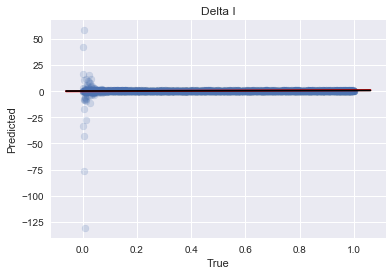

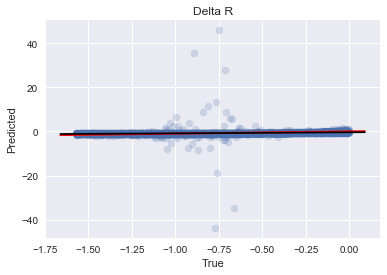

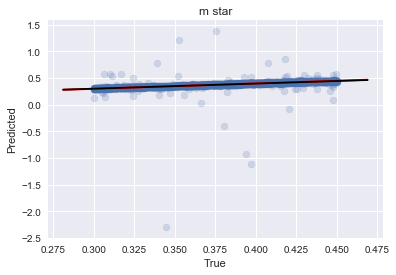

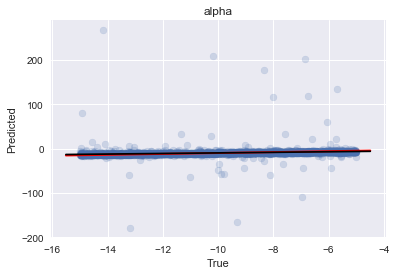

In [3]:
#Initialize and fit OLS model for deltaI 
E0_model_OLS_I_sp = sm.OLS(Y1_train['deltaI'], X1_train)
E0_model_OLS_R_sp = sm.OLS(Y1_train['deltaR'], X1_train)
E0_model_OLS_mstar_sp = sm.OLS(Y1_train['mstar'], X1_train)
E0_model_OLS_alpha_sp = sm.OLS(Y1_train['alpha'], X1_train)

E0_results_OLS_I_sp = E0_model_OLS_I_sp.fit()
E0_results_OLS_R_sp = E0_model_OLS_R_sp.fit()
E0_results_OLS_mstar_sp = E0_model_OLS_mstar_sp.fit()
E0_results_OLS_alpha_sp = E0_model_OLS_alpha_sp.fit()

#Make predictions on testing data
E0_predictions_OLS_I_sp = E0_results_OLS_I_sp.predict(X1_test) # make the predictions by the model
E0_predictions_OLS_R_sp = E0_results_OLS_R_sp.predict(X1_test)
E0_predictions_OLS_mstar_sp = E0_results_OLS_mstar_sp.predict(X1_test)
E0_predictions_OLS_alpha_sp = E0_results_OLS_alpha_sp.predict(X1_test)

E0_scores_OLS = [r2_score(Y1_test['deltaI'], E0_predictions_OLS_I_sp), 
                 r2_score(Y1_test['deltaR'], E0_predictions_OLS_R_sp),  
                 r2_score(Y1_test['mstar'], E0_predictions_OLS_mstar_sp),
                 r2_score(Y1_test['alpha'], E0_predictions_OLS_alpha_sp) ]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y1_test['deltaI'], E0_predictions_OLS_I_sp,'Delta I')
#ylim([-1,5])
plotSummary(Y1_test['deltaR'], E0_predictions_OLS_R_sp, 'Delta R')
plotSummary(Y1_test['mstar'], E0_predictions_OLS_mstar_sp, 'm star')
plotSummary(Y1_test['alpha'], E0_predictions_OLS_alpha_sp, 'alpha')




### peak info

 
RMSE on test data: 0.3276488266869769 for  Delta I
R^2 Score on test data: -0.2785903596827839 for Delta I
 
RMSE on test data: 0.5521639530688234 for  Delta R
R^2 Score on test data: -0.5093430098664535 for Delta R
 
RMSE on test data: 0.02805173172230219 for  mstar
R^2 Score on test data: 0.586317196184133 for mstar
 
RMSE on test data: 2.9220974080033124 for  alpha
R^2 Score on test data: -0.034177944998982523 for alpha


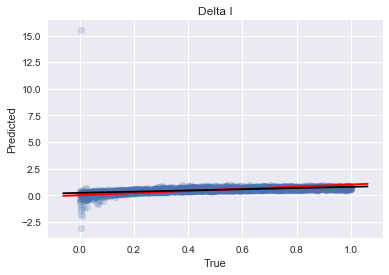

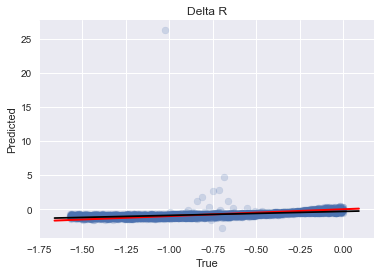

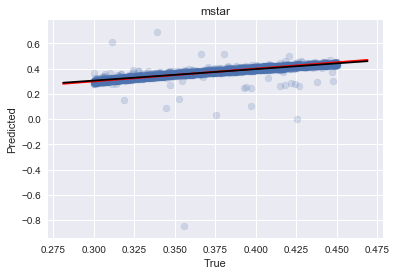

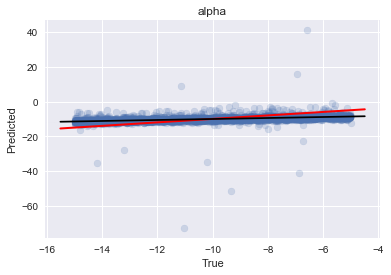

In [4]:
#Initialize and fit OLS model for deltaI 
E0_model_OLS_I_pi = sm.OLS(Y2_train['deltaI'], X2_train)
E0_model_OLS_R_pi = sm.OLS(Y2_train['deltaR'], X2_train)
E0_model_OLS_mstar_pi = sm.OLS(Y2_train['mstar'], X2_train)
E0_model_OLS_alpha_pi = sm.OLS(Y2_train['alpha'], X2_train)

E0_results_OLS_I_pi = E0_model_OLS_I_pi.fit()
E0_results_OLS_R_pi = E0_model_OLS_R_pi.fit()
E0_results_OLS_mstar_pi = E0_model_OLS_mstar_pi.fit()
E0_results_OLS_alpha_pi = E0_model_OLS_alpha_pi.fit()

#Make predictions on testing data
E0_predictions_OLS_I_pi = E0_results_OLS_I_pi.predict(X2_test) # make the predictions by the model
E0_predictions_OLS_R_pi = E0_results_OLS_R_pi.predict(X2_test)
E0_predictions_OLS_mstar_pi = E0_results_OLS_mstar_pi.predict(X2_test)
E0_predictions_OLS_alpha_pi = E0_results_OLS_alpha_pi.predict(X2_test)

E0_scores_OLS_pi = [r2_score(Y2_test['deltaI'], E0_predictions_OLS_I_pi), 
                 r2_score(Y2_test['deltaR'], E0_predictions_OLS_R_pi), 
                 r2_score(Y2_test['mstar'], E0_predictions_OLS_mstar_pi), 
                 r2_score(Y2_test['alpha'], E0_predictions_OLS_alpha_pi)]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y2_test['deltaI'], E0_predictions_OLS_I_pi,'Delta I')
#ylim([-1,5])
plotSummary(Y2_test['deltaR'], E0_predictions_OLS_R_pi, 'Delta R')

plotSummary(Y2_test['mstar'], E0_predictions_OLS_mstar_pi, 'mstar')
plotSummary(Y2_test['alpha'], E0_predictions_OLS_alpha_pi, 'alpha')

### spec points and peak info

 
RMSE on test data: 0.5181746673977599 for  Delta I
R^2 Score on test data: -2.1979122753891827 for Delta I
 
RMSE on test data: 0.8326260760767185 for  Delta R
R^2 Score on test data: -2.432036210373121 for Delta R
 
RMSE on test data: 0.014375588555743642 for  mstar
R^2 Score on test data: 0.8913575919008397 for mstar
 
RMSE on test data: 2.8894948427794676 for  alpha
R^2 Score on test data: -0.011229524344673836 for alpha


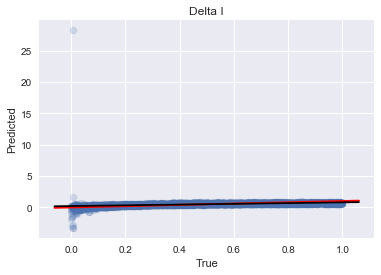

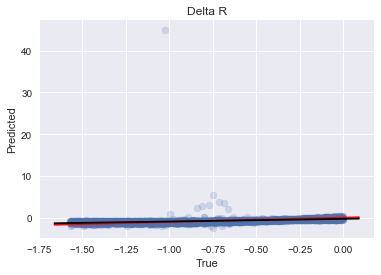

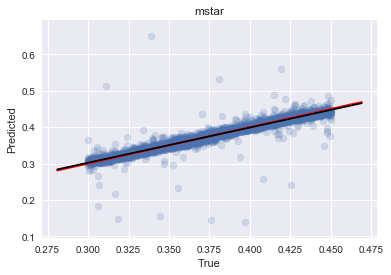

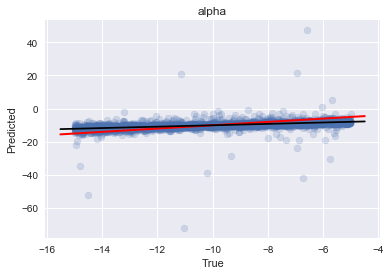

In [5]:
#Initialize and fit OLS model for deltaI 
E0_model_OLS_I_both = sm.OLS(Y_train['deltaI'], X_train)
E0_model_OLS_R_both = sm.OLS(Y_train['deltaR'], X_train)
E0_model_OLS_mstar_both = sm.OLS(Y_train['mstar'], X_train)
E0_model_OLS_alpha_both = sm.OLS(Y_train['alpha'], X_train)

E0_results_OLS_I_both = E0_model_OLS_I_both.fit()
E0_results_OLS_R_both = E0_model_OLS_R_both.fit()
E0_results_OLS_mstar_both = E0_model_OLS_mstar_both.fit()
E0_results_OLS_alpha_both = E0_model_OLS_alpha_both.fit()

#Make predictions on testing data
E0_predictions_OLS_I_both = E0_results_OLS_I_both.predict(X_test) # make the predictions by the model
E0_predictions_OLS_R_both = E0_results_OLS_R_both.predict(X_test)
E0_predictions_OLS_mstar_both = E0_results_OLS_mstar_both.predict(X_test)
E0_predictions_OLS_alpha_both = E0_results_OLS_alpha_both.predict(X_test)

E0_scores_OLS_both = [r2_score(Y_test['deltaI'], E0_predictions_OLS_I_both), 
                     r2_score(Y_test['deltaR'], E0_predictions_OLS_R_both), 
                     r2_score(Y_test['mstar'], E0_predictions_OLS_mstar_both), 
                     r2_score(Y_test['alpha'], E0_predictions_OLS_alpha_both)]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y_test['deltaI'], E0_predictions_OLS_I_both,'Delta I')
#ylim([-1,5])
plotSummary(Y_test['deltaR'], E0_predictions_OLS_R_both, 'Delta R')

plotSummary(Y_test['mstar'], E0_predictions_OLS_mstar_both, 'mstar')
plotSummary(Y_test['alpha'], E0_predictions_OLS_alpha_both, 'alpha')

## Decision Tree

### spec points

 
RMSE on test data: 0.21826214156507295 for  deltaI Depth 60
R^2 Score on test data: 0.43262392875533584 for deltaI Depth 60
 
RMSE on test data: 0.32272259183974944 for  deltaR Depth 60
R^2 Score on test data: 0.48440276110086344 for deltaR Depth 60
 
RMSE on test data: 0.016682729077052514 for  mstar
R^2 Score on test data: 0.8536872042982263 for mstar
 
RMSE on test data: 1.36415915667832 for  alpha
R^2 Score on test data: 0.774609307122161 for alpha


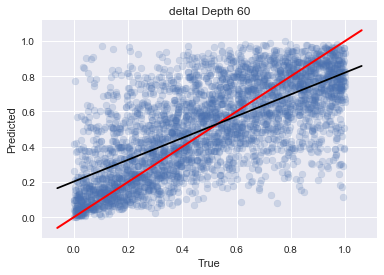

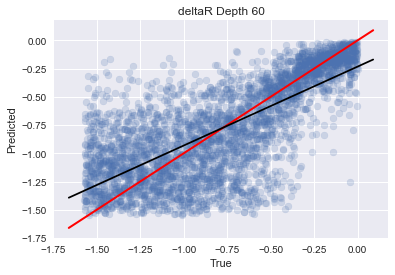

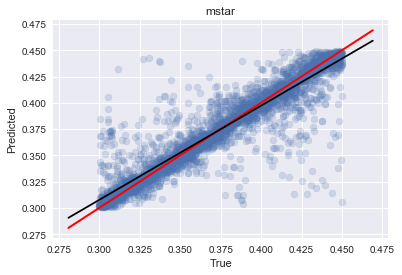

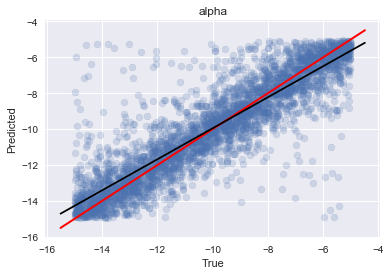

In [6]:
#Initialize the model
rs = 42
E0_regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0_regr_DT_sp = E0_regr_DT_sp.fit(X1_train, Y1_train)


#Use model to predict
E0_predictions_DT_sp = E0_regr_DT_sp.predict(X1_test)

E0_scores_DT = [r2_score(Y1_test['deltaI'], E0_predictions_DT_sp[:,0]), 
                r2_score(Y1_test['deltaR'], E0_predictions_DT_sp[:,1]), 
                r2_score(Y1_test['mstar'], E0_predictions_DT_sp[:,2]), 
                r2_score(Y1_test['alpha'], E0_predictions_DT_sp[:,3]) ]

#Plot results
plotSummary(Y1_test['deltaI'], E0_predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], E0_predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
plotSummary(Y1_test['mstar'], E0_predictions_DT_sp[:,2], 'mstar')
plotSummary(Y1_test['alpha'], E0_predictions_DT_sp[:,3], 'alpha')




### peak info

 
RMSE on test data: 0.1980247121787449 for  deltaI Depth 60
R^2 Score on test data: 0.5329611880239871 for deltaI Depth 60
 
RMSE on test data: 0.3053240931067271 for  deltaR Depth 60
R^2 Score on test data: 0.5384975647662961 for deltaR Depth 60
 
RMSE on test data: 0.009593308635602845 for  mstar DT pi
R^2 Score on test data: 0.9516178739824133 for mstar DT pi
 
RMSE on test data: 1.4857530848454785 for  alpha
R^2 Score on test data: 0.7326383117136774 for alpha


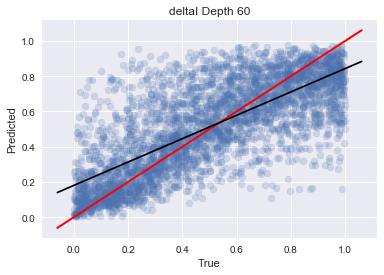

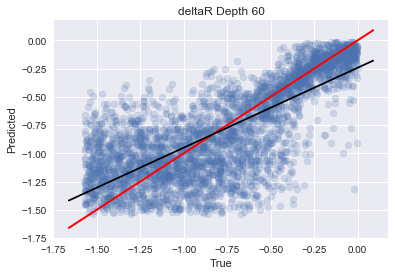

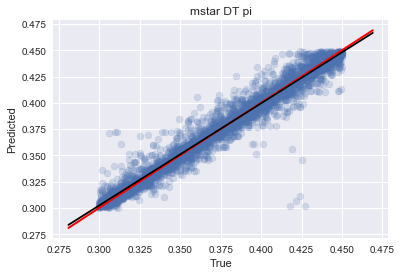

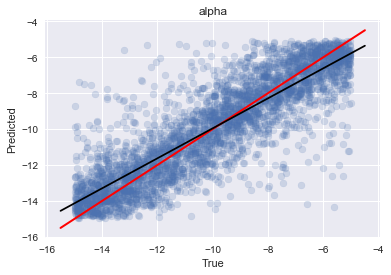

In [7]:
#Initialize the model
rs = 42
E0_regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0_regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0_predictions_DT_pi = E0_regr_DT_pi.predict(X2_test)

E0_scores_DT_pi = [r2_score(Y2_test['deltaI'], E0_predictions_DT_pi[:,0]), 
                r2_score(Y2_test['deltaR'], E0_predictions_DT_pi[:,1]), 
                r2_score(Y2_test['mstar'], E0_predictions_DT_pi[:,2]), 
                r2_score(Y2_test['alpha'], E0_predictions_DT_pi[:,3])]

#Plot results
plotSummary(Y2_test['deltaI'], E0_predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], E0_predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

plotSummary(Y2_test['mstar'], E0_predictions_DT_pi[:,2], 'mstar DT pi')
plotSummary(Y2_test['alpha'], E0_predictions_DT_pi[:,3], 'alpha')

### spec points and peak info

 
RMSE on test data: 0.21665506352416597 for  deltaI Depth 60
R^2 Score on test data: 0.4409484208813055 for deltaI Depth 60
 
RMSE on test data: 0.3174427770310147 for  deltaR Depth 60
R^2 Score on test data: 0.5011353334516601 for deltaR Depth 60
 
RMSE on test data: 0.010184956868480527 for  mstar DT both
R^2 Score on test data: 0.9454661068277592 for mstar DT both
 
RMSE on test data: 1.2045314463214793 for  alpha
R^2 Score on test data: 0.8242715094494059 for alpha


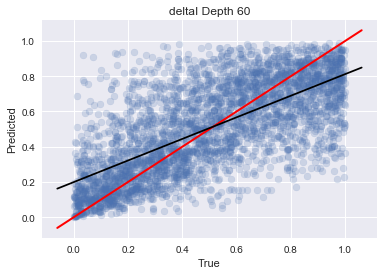

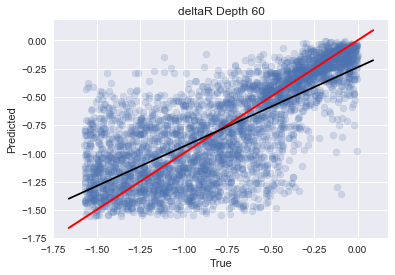

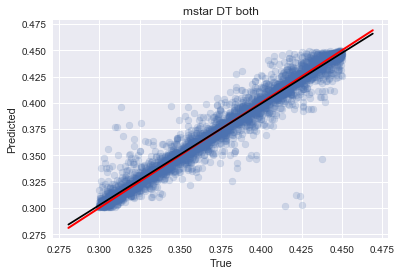

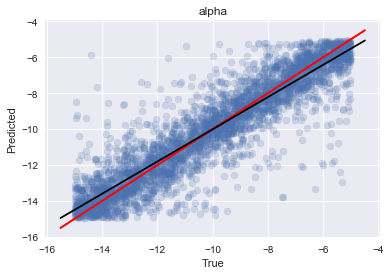

In [8]:
#Initialize the model
rs = 42
E0_regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0_regr_DT_both.fit(X_train, Y_train)

#Use model to predict
E0_predictions_DT_both = E0_regr_DT_both.predict(X_test)

E0_scores_DT_both = [r2_score(Y_test['deltaI'], E0_predictions_DT_both[:,0]), 
                r2_score(Y_test['deltaR'], E0_predictions_DT_both[:,1]), 
                r2_score(Y_test['mstar'], E0_predictions_DT_both[:,2]), 
                r2_score(Y_test['alpha'], E0_predictions_DT_both[:,3])]

#Plot results
plotSummary(Y_test['deltaI'], E0_predictions_DT_both[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], E0_predictions_DT_both[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

plotSummary(Y_test['mstar'], E0_predictions_DT_both[:,2], 'mstar DT both')
plotSummary(Y_test['alpha'], E0_predictions_DT_both[:,3], 'alpha')

## Random Forest

### spec points

 
RMSE on test data: 0.15351982564627045 for  deltaI 10
R^2 Score on test data: 0.7192995373477612 for deltaI 10
 
RMSE on test data: 0.2258621267444044 for  deltaR 10
R^2 Score on test data: 0.7474550597594278 for deltaR 10
 
RMSE on test data: 0.008139369262928329 for  mstar
R^2 Score on test data: 0.9651719131902831 for mstar
 
RMSE on test data: 0.8738729113980279 for  alpha
R^2 Score on test data: 0.9075083668511796 for alpha


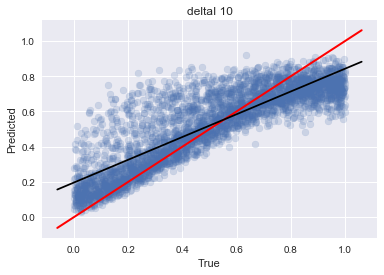

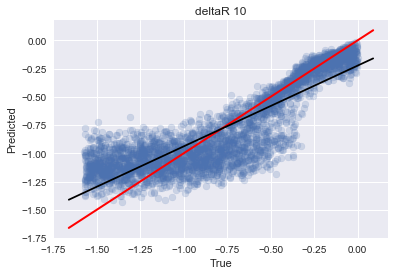

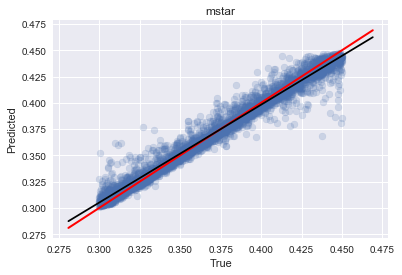

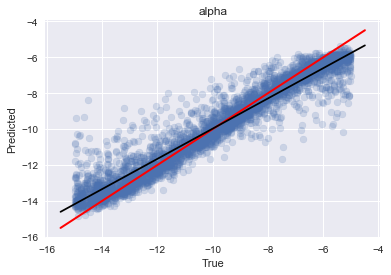

In [9]:
rs = 42
E0_regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0_model_RF_sp = E0_regr_RF_sp.fit(X1_train, Y1_train)

E0_predictions_RF_sp = E0_model_RF_sp.predict(X1_test)

E0_scores_RF = [r2_score(Y1_test['deltaI'], E0_predictions_RF_sp[:,0]), 
                r2_score(Y1_test['deltaR'], E0_predictions_RF_sp[:,1]), 
                r2_score(Y1_test['mstar'], E0_predictions_RF_sp[:,2]), 
                r2_score(Y1_test['alpha'], E0_predictions_RF_sp[:,3])]

plotSummary(Y1_test['deltaI'], E0_predictions_RF_sp[:,0], 'deltaI 10')
plotSummary(Y1_test['deltaR'], E0_predictions_RF_sp[:,1], 'deltaR 10')
plotSummary(Y1_test['mstar'], E0_predictions_RF_sp[:,2], 'mstar')
plotSummary(Y1_test['alpha'], E0_predictions_RF_sp[:,3], 'alpha')


### peak info

 
RMSE on test data: 0.14978183798608086 for  deltaI 10
R^2 Score on test data: 0.7328024310018644 for deltaI 10
 
RMSE on test data: 0.24585907608798627 for  deltaR 10
R^2 Score on test data: 0.7007567685445455 for deltaR 10
 
RMSE on test data: 0.007418074710901747 for  mstar
R^2 Score on test data: 0.9710711932249789 for mstar
 
RMSE on test data: 1.1635477482276944 for  alpha
R^2 Score on test data: 0.8360262557284894 for alpha


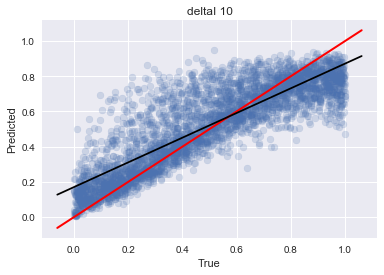

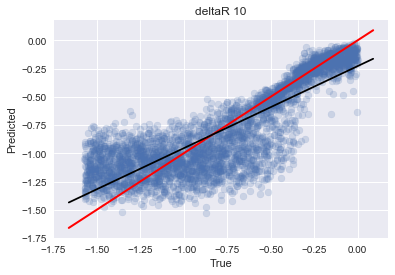

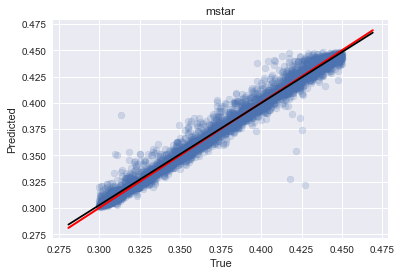

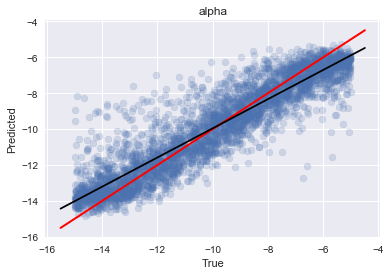

In [10]:
rs = 42
E0_regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0_model_RF_pi = E0_regr_RF_pi.fit(X2_train, Y2_train)

E0_predictions_RF_pi = E0_model_RF_pi.predict(X2_test)

E0_scores_RF_pi = [r2_score(Y2_test['deltaI'], E0_predictions_RF_pi[:,0]), 
                   r2_score(Y2_test['deltaR'], E0_predictions_RF_pi[:,1]), 
                   r2_score(Y2_test['mstar'], E0_predictions_RF_pi[:,2]), 
                   r2_score(Y2_test['alpha'], E0_predictions_RF_pi[:,3])]

plotSummary(Y2_test['deltaI'], E0_predictions_RF_pi[:,0], 'deltaI 10')
plotSummary(Y2_test['deltaR'], E0_predictions_RF_pi[:,1], 'deltaR 10')
plotSummary(Y2_test['mstar'], E0_predictions_RF_pi[:,2], 'mstar')
plotSummary(Y2_test['alpha'], E0_predictions_RF_pi[:,3], 'alpha')

### spec points and peak info

 
RMSE on test data: 0.14787873147737174 for  deltaI 10
R^2 Score on test data: 0.7395492427781061 for deltaI 10
 
RMSE on test data: 0.2240145523822497 for  deltaR 10
R^2 Score on test data: 0.7515698457561389 for deltaR 10
 
RMSE on test data: 0.007328167404726611 for  mstar
R^2 Score on test data: 0.9717681798759269 for mstar
 
RMSE on test data: 0.8493260646953875 for  alpha
R^2 Score on test data: 0.9126315163823545 for alpha


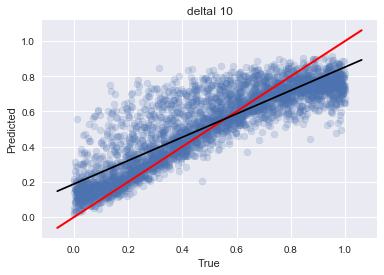

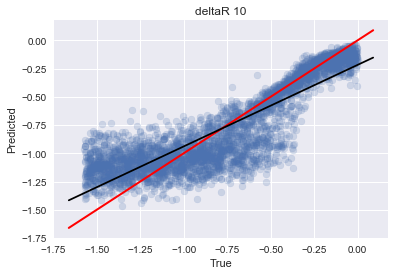

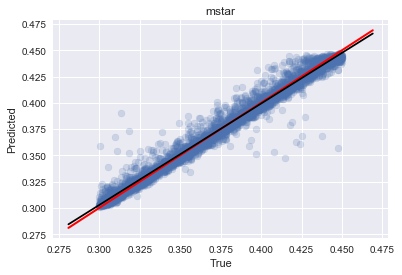

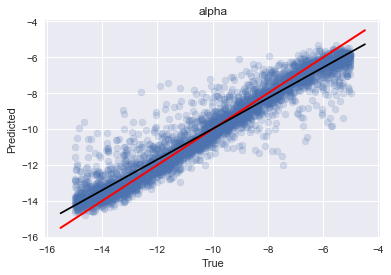

In [11]:
rs = 42
E0_regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0_model_RF_both = E0_regr_RF_both.fit(X_train, Y_train)

E0_predictions_RF_both = E0_model_RF_both.predict(X_test)

E0_scores_RF_both = [r2_score(Y_test['deltaI'], E0_predictions_RF_both[:,0]), 
                   r2_score(Y_test['deltaR'], E0_predictions_RF_both[:,1]), 
                   r2_score(Y_test['mstar'], E0_predictions_RF_both[:,2]), 
                   r2_score(Y_test['alpha'], E0_predictions_RF_both[:,3])]

plotSummary(Y_test['deltaI'], E0_predictions_RF_both[:,0], 'deltaI 10')
plotSummary(Y_test['deltaR'], E0_predictions_RF_both[:,1], 'deltaR 10')
plotSummary(Y_test['mstar'], E0_predictions_RF_both[:,2], 'mstar')
plotSummary(Y_test['alpha'], E0_predictions_RF_both[:,3], 'alpha')

## Independent Random Forests

### spec points

 
RMSE on test data: 0.19233625848318311 for  deltaI 10
R^2 Score on test data: 0.8168638110330789 for deltaI 10
 
RMSE on test data: 0.12102536778167618 for  deltaR 10
R^2 Score on test data: 0.8255515907357637 for deltaR 10
 
RMSE on test data: 0.005529463209457708 for  mstar
R^2 Score on test data: 0.9839263665481918 for mstar
 
RMSE on test data: 0.8536281382538734 for  alpha
R^2 Score on test data: 0.9117441832577229 for alpha


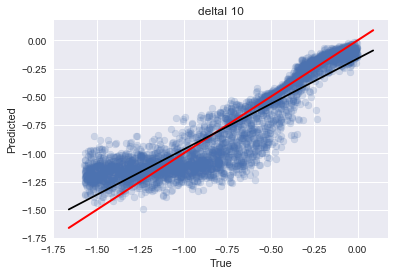

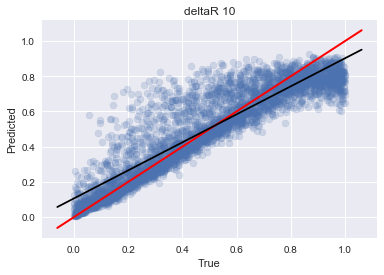

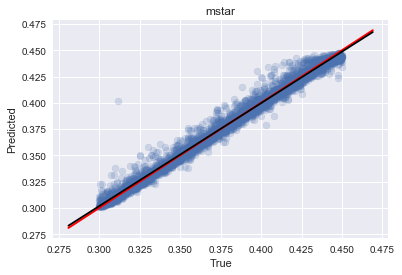

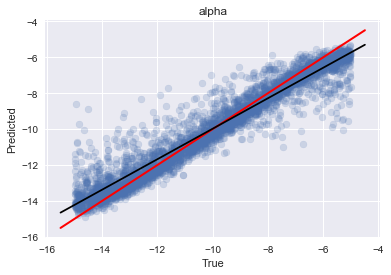

In [12]:
#Trying Independent Random Forest

rs = 42
md = 40
n = 40

E0_regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_mstar_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_alpha_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)


E0_model_RF2_dr_sp = E0_regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
E0_model_RF2_di_sp = E0_regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
E0_model_RF2_mstar_sp = E0_regr_RF2_mstar_sp.fit(X1_train, Y1_train['mstar'])
E0_model_RF2_alpha_sp = E0_regr_RF2_alpha_sp.fit(X1_train, Y1_train['alpha'])

E0_predictions_RF2_dr_sp = E0_model_RF2_dr_sp.predict(X1_test)
E0_predictions_RF2_di_sp = E0_model_RF2_di_sp.predict(X1_test)
E0_predictions_RF2_mstar_sp = E0_model_RF2_mstar_sp.predict(X1_test)
E0_predictions_RF2_alpha_sp = E0_model_RF2_alpha_sp.predict(X1_test)

E0_scores_RF2 = [r2_score(Y1_test['deltaI'], E0_predictions_RF2_di_sp), 
              r2_score(Y1_test['deltaR'], E0_predictions_RF2_dr_sp), 
              r2_score(Y1_test['mstar'], E0_predictions_RF2_mstar_sp), 
              r2_score(Y1_test['alpha'], E0_predictions_RF2_alpha_sp)]

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

plotSummary(Y1_test['deltaR'], E0_predictions_RF2_dr_sp, 'deltaI 10')
plotSummary(Y1_test['deltaI'], E0_predictions_RF2_di_sp, 'deltaR 10')
plotSummary(Y1_test['mstar'], E0_predictions_RF2_mstar_sp, 'mstar')
plotSummary(Y1_test['alpha'], E0_predictions_RF2_alpha_sp, 'alpha')



### peak info

 
RMSE on test data: 0.10113706367277174 for  deltaI 10
R^2 Score on test data: 0.9493624684812886 for deltaI 10
 
RMSE on test data: 0.042363996201736115 for  deltaR 10
R^2 Score on test data: 0.9786249060477757 for deltaR 10
 
RMSE on test data: 0.005985904816842727 for  mstar
R^2 Score on test data: 0.9811631739098523 for mstar
 
RMSE on test data: 1.1527677913598267 for  alpha
R^2 Score on test data: 0.8390505262591765 for alpha


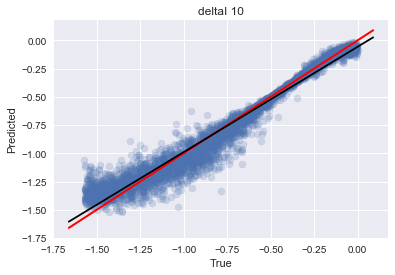

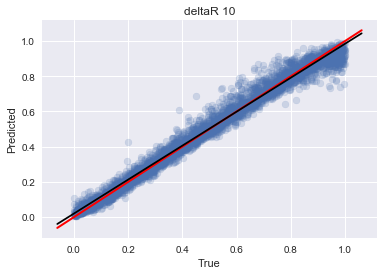

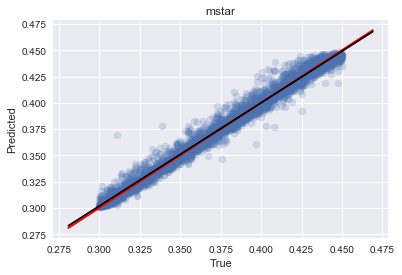

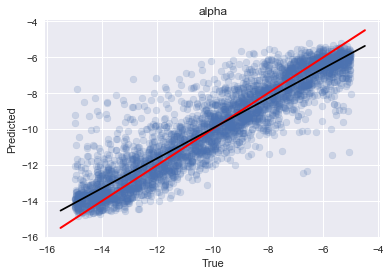

In [13]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0_regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_mstar_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_alpha_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0_model_RF2_dr_pi = E0_regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])
E0_model_RF2_di_pi = E0_regr_RF2_di_pi.fit(X2_train, Y2_train['deltaI'])
E0_model_RF2_mstar_pi = E0_regr_RF2_mstar_pi.fit(X2_train, Y2_train['mstar'])
E0_model_RF2_alpha_pi = E0_regr_RF2_alpha_pi.fit(X2_train, Y2_train['alpha'])

E0_predictions_RF2_dr_pi = E0_model_RF2_dr_pi.predict(X2_test)
E0_predictions_RF2_di_pi = E0_model_RF2_di_pi.predict(X2_test)
E0_predictions_RF2_mstar_pi = E0_model_RF2_mstar_pi.predict(X2_test)
E0_predictions_RF2_alpha_pi = E0_model_RF2_alpha_pi.predict(X2_test)

E0_scores_RF2_pi = [r2_score(Y2_test['deltaI'], E0_predictions_RF2_di_pi), 
                 r2_score(Y2_test['deltaR'], E0_predictions_RF2_dr_pi), 
                 r2_score(Y2_test['mstar'], E0_predictions_RF2_mstar_pi), 
                 r2_score(Y2_test['alpha'], E0_predictions_RF2_alpha_pi)]

plotSummary(Y2_test['deltaR'], E0_predictions_RF2_dr_pi, 'deltaI 10')
plotSummary(Y2_test['deltaI'], E0_predictions_RF2_di_pi, 'deltaR 10')
plotSummary(Y2_test['mstar'], E0_predictions_RF2_mstar_pi, 'mstar')
plotSummary(Y2_test['alpha'], E0_predictions_RF2_alpha_pi, 'alpha')


### spec points and peak info

 
RMSE on test data: 0.1445511111410578 for  deltaI 10
R^2 Score on test data: 0.8965585227306041 for deltaI 10
 
RMSE on test data: 0.057541903831785327 for  deltaR 10
R^2 Score on test data: 0.9605649273568945 for deltaR 10
 
RMSE on test data: 0.005991540257812997 for  mstar
R^2 Score on test data: 0.9811276892858558 for mstar
 
RMSE on test data: 0.8157338501024947 for  alpha
R^2 Score on test data: 0.9194059718965188 for alpha


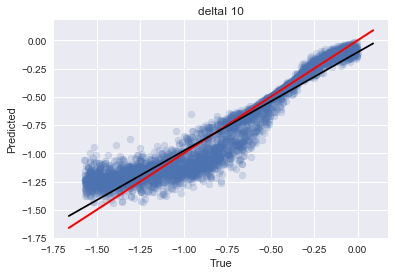

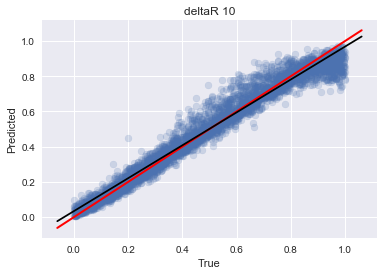

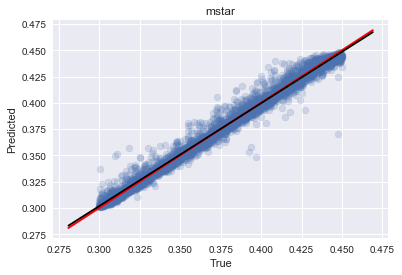

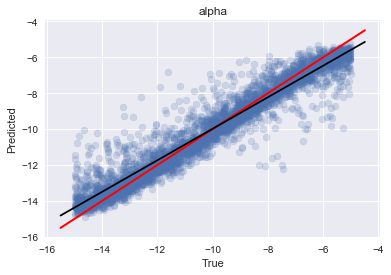

In [14]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0_regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_di_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_mstar_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0_regr_RF2_alpha_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0_model_RF2_dr_both = E0_regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])
E0_model_RF2_di_both = E0_regr_RF2_di_both.fit(X_train, Y_train['deltaI'])
E0_model_RF2_mstar_both = E0_regr_RF2_mstar_both.fit(X_train, Y_train['mstar'])
E0_model_RF2_alpha_both = E0_regr_RF2_alpha_both.fit(X_train, Y_train['alpha'])

E0_predictions_RF2_dr_both = E0_model_RF2_dr_both.predict(X_test)
E0_predictions_RF2_di_both = E0_model_RF2_di_both.predict(X_test)
E0_predictions_RF2_mstar_both = E0_model_RF2_mstar_both.predict(X_test)
E0_predictions_RF2_alpha_both = E0_model_RF2_alpha_both.predict(X_test)

E0_scores_RF2_both = [r2_score(Y_test['deltaI'], E0_predictions_RF2_di_both), 
                 r2_score(Y_test['deltaR'], E0_predictions_RF2_dr_both), 
                 r2_score(Y_test['mstar'], E0_predictions_RF2_mstar_both), 
                 r2_score(Y_test['alpha'], E0_predictions_RF2_alpha_both)]

plotSummary(Y_test['deltaR'], E0_predictions_RF2_dr_both, 'deltaI 10')
plotSummary(Y_test['deltaI'], E0_predictions_RF2_di_both, 'deltaR 10')
plotSummary(Y_test['mstar'], E0_predictions_RF2_mstar_both, 'mstar')
plotSummary(Y_test['alpha'], E0_predictions_RF2_alpha_both, 'alpha')



## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.12510251134529163 for  AdaBoost Delta I
R^2 Score on test data: 0.8135998543678493 for AdaBoost Delta I
 
RMSE on test data: 0.2051576528377401 for  AdaBoost Delta R
R^2 Score on test data: 0.7916337916415299 for AdaBoost Delta R
 
RMSE on test data: 0.005606058162016644 for  AdaBoost mstar
R^2 Score on test data: 0.9834779735503575 for AdaBoost mstar
 
RMSE on test data: 0.8423216808942854 for  AdaBoost alpha
R^2 Score on test data: 0.9140666282734509 for AdaBoost alpha


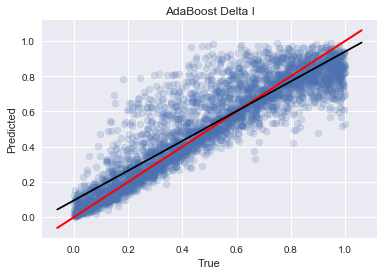

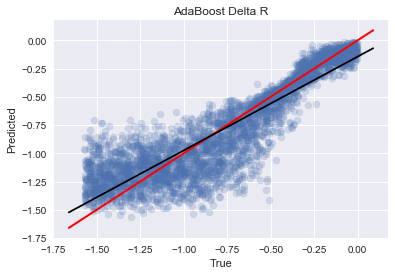

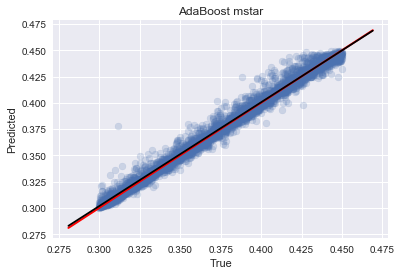

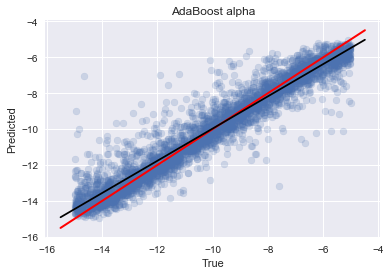

In [15]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0_regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0_regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
E0_regr_AB_mstar_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)
E0_regr_AB_alpha_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

E0_model_AB_di_sp = E0_regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
E0_model_AB_dr_sp = E0_regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
E0_model_AB_mstar_sp = E0_regr_AB_mstar_sp.fit(X1_train, Y1_train['mstar'])
E0_model_AB_alpha_sp = E0_regr_AB_alpha_sp.fit(X1_train, Y1_train['alpha'])

E0_predictions_AB_di_sp = E0_model_AB_di_sp.predict(X1_test)
E0_predictions_AB_dr_sp = E0_model_AB_dr_sp.predict(X1_test)
E0_predictions_AB_mstar_sp = E0_model_AB_mstar_sp.predict(X1_test)
E0_predictions_AB_alpha_sp = E0_model_AB_alpha_sp.predict(X1_test)

E0_scores_AB = [r2_score(Y1_test['deltaI'], E0_predictions_AB_di_sp), 
             r2_score(Y1_test['deltaR'], E0_predictions_AB_dr_sp), 
             r2_score(Y1_test['mstar'], E0_predictions_AB_mstar_sp), 
             r2_score(Y1_test['alpha'], E0_predictions_AB_alpha_sp)]

plotSummary(Y1_test['deltaI'], E0_predictions_AB_di_sp, 'AdaBoost Delta I')
plotSummary(Y1_test['deltaR'], E0_predictions_AB_dr_sp, 'AdaBoost Delta R')
plotSummary(Y1_test['mstar'], E0_predictions_AB_mstar_sp, 'AdaBoost mstar')
plotSummary(Y1_test['alpha'], E0_predictions_AB_alpha_sp, 'AdaBoost alpha')




### peak info

 
RMSE on test data: 0.04462736815060481 for  AdaBoost Delta I
R^2 Score on test data: 0.9762798876037712 for AdaBoost Delta I
 
RMSE on test data: 0.10403662090723159 for  AdaBoost Delta R
R^2 Score on test data: 0.9464173336035046 for AdaBoost Delta R
 
RMSE on test data: 0.0063303454130190185 for  AdaBoost mstar
R^2 Score on test data: 0.9789329885997106 for AdaBoost mstar
 
RMSE on test data: 1.2343204151521159 for  AdaBoost alpha
R^2 Score on test data: 0.8154722365861338 for AdaBoost alpha


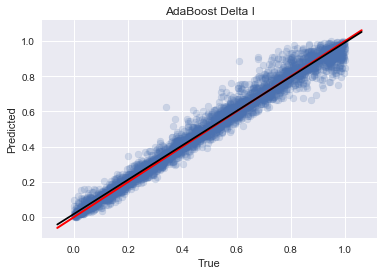

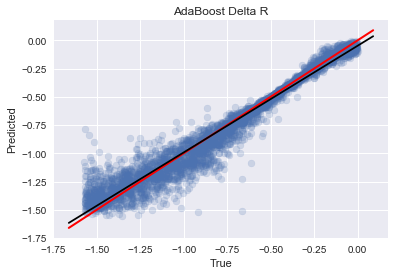

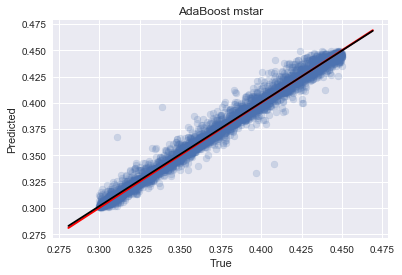

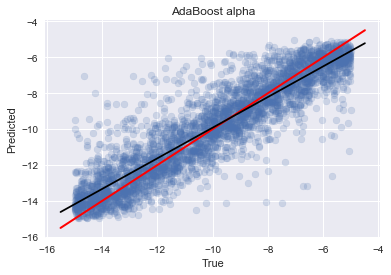

In [16]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0_regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0_regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
E0_regr_AB_mstar_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)
E0_regr_AB_alpha_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

E0_model_AB_di_pi = E0_regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
E0_model_AB_dr_pi = E0_regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])
E0_model_AB_mstar_pi = E0_regr_AB_mstar_pi.fit(X2_train, Y2_train['mstar'])
E0_model_AB_alpha_pi = E0_regr_AB_alpha_pi.fit(X2_train, Y2_train['alpha'])

E0_predictions_AB_di_pi = E0_model_AB_di_pi.predict(X2_test)
E0_predictions_AB_dr_pi = E0_model_AB_dr_pi.predict(X2_test)
E0_predictions_AB_mstar_pi = E0_model_AB_mstar_pi.predict(X2_test)
E0_predictions_AB_alpha_pi = E0_model_AB_alpha_pi.predict(X2_test)

E0_scores_AB_pi = [r2_score(Y2_test['deltaI'], E0_predictions_AB_di_pi), 
                r2_score(Y2_test['deltaR'], E0_predictions_AB_dr_pi), 
                r2_score(Y2_test['mstar'], E0_predictions_AB_mstar_pi), 
                r2_score(Y2_test['alpha'], E0_predictions_AB_alpha_pi)]

plotSummary(Y2_test['deltaI'], E0_predictions_AB_di_pi, 'AdaBoost Delta I')
plotSummary(Y2_test['deltaR'], E0_predictions_AB_dr_pi, 'AdaBoost Delta R')
plotSummary(Y2_test['mstar'], E0_predictions_AB_mstar_pi, 'AdaBoost mstar')
plotSummary(Y2_test['alpha'], E0_predictions_AB_alpha_pi, 'AdaBoost alpha')




### spec points and peak info

 
RMSE on test data: 0.06100659905584427 for  AdaBoost Delta I
R^2 Score on test data: 0.9556730529034932 for AdaBoost Delta I
 
RMSE on test data: 0.14418749945151374 for  AdaBoost Delta R
R^2 Score on test data: 0.8970782727861375 for AdaBoost Delta R
 
RMSE on test data: 0.005719062570374992 for  AdaBoost mstar
R^2 Score on test data: 0.9828051729952694 for AdaBoost mstar
 
RMSE on test data: 0.8408638947384626 for  AdaBoost alpha
R^2 Score on test data: 0.9143638165790838 for AdaBoost alpha


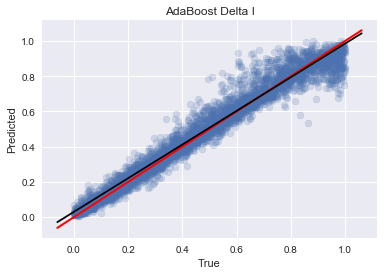

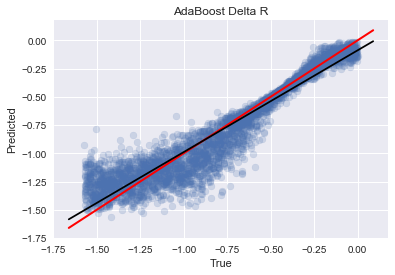

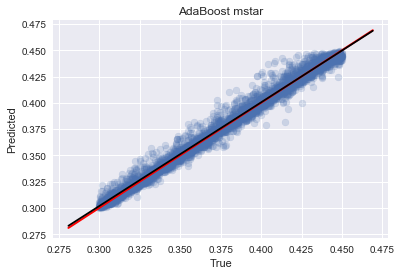

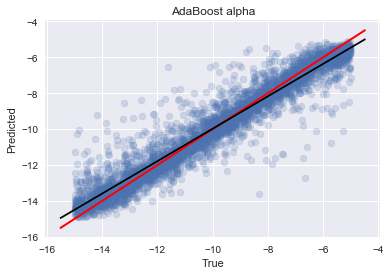

In [17]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0_regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0_regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
E0_regr_AB_mstar_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)
E0_regr_AB_alpha_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators = nest2, random_state = rng)

E0_model_AB_di_both = E0_regr_AB_di_both.fit(X_train, Y_train['deltaI'])
E0_model_AB_dr_both = E0_regr_AB_dr_both.fit(X_train, Y_train['deltaR'])
E0_model_AB_mstar_both = E0_regr_AB_mstar_both.fit(X_train, Y_train['mstar'])
E0_model_AB_alpha_both = E0_regr_AB_alpha_both.fit(X_train, Y_train['alpha'])

E0_predictions_AB_di_both = E0_model_AB_di_both.predict(X_test)
E0_predictions_AB_dr_both = E0_model_AB_dr_both.predict(X_test)
E0_predictions_AB_mstar_both = E0_model_AB_mstar_both.predict(X_test)
E0_predictions_AB_alpha_both = E0_model_AB_alpha_both.predict(X_test)

E0_scores_AB_both = [r2_score(Y_test['deltaI'], E0_predictions_AB_di_both), 
                r2_score(Y_test['deltaR'], E0_predictions_AB_dr_both), 
                r2_score(Y_test['mstar'], E0_predictions_AB_mstar_both), 
                r2_score(Y_test['alpha'], E0_predictions_AB_alpha_both)]

plotSummary(Y_test['deltaI'], E0_predictions_AB_di_both, 'AdaBoost Delta I')
plotSummary(Y_test['deltaR'], E0_predictions_AB_dr_both, 'AdaBoost Delta R')
plotSummary(Y_test['mstar'], E0_predictions_AB_mstar_both, 'AdaBoost mstar')
plotSummary(Y_test['alpha'], E0_predictions_AB_alpha_both, 'AdaBoost alpha')


## Gradient Boosting Random Forest

### spec points

In [ ]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0_regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_mstar_sp = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)
E0_regr_GB_alpha_sp = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)

E0_model_GB_di_sp = E0_regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
E0_model_GB_dr_sp = E0_regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
E0_model_GB_mstar_sp = E0_regr_GB_mstar_sp.fit(X1_train, Y1_train['mstar'])
E0_model_GB_alpha_sp = E0_regr_GB_alpha_sp.fit(X1_train, Y1_train['alpha'])


E0_predictions_GB_di_sp = E0_model_GB_di_sp.predict(X1_test)
E0_predictions_GB_dr_sp = E0_model_GB_dr_sp.predict(X1_test)
E0_predictions_GB_mstar_sp = E0_model_GB_mstar_sp.predict(X1_test)
E0_predictions_GB_alpha_sp = E0_model_GB_alpha_sp.predict(X1_test)

E0_scores_GB = [r2_score(Y1_test['deltaI'], E0_predictions_GB_di_sp), 
                r2_score(Y1_test['deltaR'], E0_predictions_GB_dr_sp), 
                r2_score(Y1_test['mstar'], E0_predictions_GB_mstar_sp), 
                r2_score(Y1_test['alpha'], E0_predictions_GB_alpha_sp)]

plotSummary(Y1_test['deltaI'], E0_predictions_GB_di_sp, 'GradientBoost Delta I')
plotSummary(Y1_test['deltaR'], E0_predictions_GB_dr_sp, 'GradientBoost Delta R')
plotSummary(Y1_test['mstar'], E0_predictions_GB_mstar_sp, 'GradientBoost mstar')
plotSummary(Y1_test['alpha'], E0_predictions_GB_alpha_sp, 'GradientBoost alpha')





### peak info

In [ ]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0_regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_mstar_pi = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)
E0_regr_GB_alpha_pi = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)

E0_model_GB_di_pi = E0_regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])
E0_model_GB_dr_pi = E0_regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])
E0_model_GB_mstar_pi = E0_regr_GB_mstar_pi.fit(X2_train, Y2_train['mstar'])
E0_model_GB_alpha_pi = E0_regr_GB_alpha_pi.fit(X2_train, Y2_train['alpha'])

E0_predictions_GB_di_pi = E0_model_GB_di_pi.predict(X2_test)
E0_predictions_GB_dr_pi = E0_model_GB_dr_pi.predict(X2_test)
E0_predictions_GB_mstar_pi = E0_model_GB_mstar_pi.predict(X2_test)
E0_predictions_GB_alpha_pi = E0_model_GB_alpha_pi.predict(X2_test)

E0_scores_GB_pi = [r2_score(Y2_test['deltaI'], E0_predictions_GB_di_pi), 
                r2_score(Y2_test['deltaR'], E0_predictions_GB_dr_pi), 
                r2_score(Y2_test['mstar'], E0_predictions_GB_mstar_pi), 
                r2_score(Y2_test['alpha'], E0_predictions_GB_alpha_pi)]

plotSummary(Y2_test['deltaI'], E0_predictions_GB_di_pi, 'GradientBoost Delta I')
plotSummary(Y2_test['deltaR'], E0_predictions_GB_dr_pi, 'GradientBoost Delta R')
plotSummary(Y2_test['mstar'], E0_predictions_GB_mstar_pi, 'GradientBoost mstar')
plotSummary(Y2_test['alpha'], E0_predictions_GB_alpha_pi, 'GradientBoost alpha')



### spec points and peak info

In [ ]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0_regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0_regr_GB_mstar_both = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)
E0_regr_GB_alpha_both = GradientBoostingRegressor(max_depth = md, n_estimators = nest2, random_state = rng)

E0_model_GB_di_both = E0_regr_GB_di_both.fit(X_train, Y_train['deltaI'])
E0_model_GB_dr_both = E0_regr_GB_dr_both.fit(X_train, Y_train['deltaR'])
E0_model_GB_mstar_both = E0_regr_GB_mstar_both.fit(X_train, Y_train['mstar'])
E0_model_GB_alpha_both = E0_regr_GB_alpha_both.fit(X_train, Y_train['alpha'])

E0_predictions_GB_di_both = E0_model_GB_di_both.predict(X_test)
E0_predictions_GB_dr_both = E0_model_GB_dr_both.predict(X_test)
E0_predictions_GB_mstar_both = E0_model_GB_mstar_both.predict(X_test)
E0_predictions_GB_alpha_both = E0_model_GB_alpha_both.predict(X_test)

E0_scores_GB_both = [r2_score(Y_test['deltaI'], E0_predictions_GB_di_both), 
                r2_score(Y_test['deltaR'], E0_predictions_GB_dr_both), 
                r2_score(Y_test['mstar'], E0_predictions_GB_mstar_both), 
                r2_score(Y_test['alpha'], E0_predictions_GB_alpha_both)]

plotSummary(Y_test['deltaI'], E0_predictions_GB_di_both, 'GradientBoost Delta I')
plotSummary(Y_test['deltaR'], E0_predictions_GB_dr_both, 'GradientBoost Delta R')
plotSummary(Y_test['mstar'], E0_predictions_GB_mstar_both, 'GradientBoost mstar')
plotSummary(Y_test['alpha'], E0_predictions_GB_alpha_both, 'GradientBoost alpha')



## Testing on Experimental Data

In [ ]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_peakinfo.csv', header = None, names = col_names3)

col_names_exp_both = col_names_both[5:]
col_names_exp_pi = col_names2a[5:]
col_names_exp_a = col_names_a[5:]

exp_data_both = exp_data_sp.join(exp_data_pi, how = 'left')
exp_data_both = exp_data_both[col_names_exp_both]

exp_data_sp = exp_data_sp[col_names_exp_a]
exp_data_pi = exp_data_pi[col_names_exp_pi]

E0_pred_phase_OLS_R_sp = E0_results_OLS_R_sp.predict(exp_data_sp)
E0_pred_phase_OLS_I_sp = E0_results_OLS_I_sp.predict(exp_data_sp)
E0_pred_phase_OLS_mstar_sp = E0_results_OLS_mstar_sp.predict(exp_data_sp)
E0_pred_phase_OLS_alpha_sp = E0_results_OLS_alpha_sp.predict(exp_data_sp)

E0_pred_phase_OLS_R_pi = E0_results_OLS_R_pi.predict(exp_data_pi)
E0_pred_phase_OLS_I_pi = E0_results_OLS_I_pi.predict(exp_data_pi)
E0_pred_phase_OLS_mstar_pi = E0_results_OLS_mstar_pi.predict(exp_data_pi)
E0_pred_phase_OLS_alpha_pi = E0_results_OLS_alpha_pi.predict(exp_data_pi)

E0_pred_phase_OLS_R_both = E0_results_OLS_R_both.predict(exp_data_both)
E0_pred_phase_OLS_I_both = E0_results_OLS_I_both.predict(exp_data_both)
E0_pred_phase_OLS_mstar_both = E0_results_OLS_mstar_both.predict(exp_data_both)
E0_pred_phase_OLS_alpha_both = E0_results_OLS_alpha_both.predict(exp_data_both)

E0_phases_OLS_sp = [E0_pred_phase_OLS_I_sp[0], 
                    E0_pred_phase_OLS_R_pi[0], 
                    E0_pred_phase_OLS_mstar_sp[0], 
                    E0_pred_phase_OLS_alpha_sp[0]]

E0_phases_OLS_pi = [E0_pred_phase_OLS_I_pi[0], 
                    E0_pred_phase_OLS_R_pi[0], 
                    E0_pred_phase_OLS_mstar_pi[0], 
                    E0_pred_phase_OLS_alpha_pi[0]]

E0_phases_OLS_both = [E0_pred_phase_OLS_I_both[0], 
                    E0_pred_phase_OLS_R_both[0], 
                    E0_pred_phase_OLS_mstar_both[0], 
                    E0_pred_phase_OLS_alpha_both[0]]

#pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT = np.append(pred_phase_DT, r2_score(Y_test['scale_factor'], y_pred_DT[:,2]))
E0_phases_DT_sp = E0_regr_DT_sp.predict(exp_data_sp)
E0_phases_DT_pi = E0_regr_DT_pi.predict(exp_data_pi)
E0_phases_DT_both = E0_regr_DT_both.predict(exp_data_both)

E0_phases_RF_sp = E0_regr_RF_sp.predict(exp_data_sp)
E0_phases_RF_pi = E0_regr_RF_pi.predict(exp_data_pi)
E0_phases_RF_both = E0_regr_RF_both.predict(exp_data_both)

E0_pred_phase_AB_R_sp = E0_model_AB_dr_sp.predict(exp_data_sp)
E0_pred_phase_AB_I_sp = E0_model_AB_di_sp.predict(exp_data_sp)
E0_pred_phase_AB_mstar_sp = E0_model_AB_mstar_sp.predict(exp_data_sp)
E0_pred_phase_AB_alpha_sp = E0_model_AB_alpha_sp.predict(exp_data_sp)

E0_pred_phase_AB_R_pi = E0_model_AB_dr_pi.predict(exp_data_pi)
E0_pred_phase_AB_I_pi = E0_model_AB_di_pi.predict(exp_data_pi)
E0_pred_phase_AB_mstar_pi = E0_model_AB_mstar_pi.predict(exp_data_pi)
E0_pred_phase_AB_alpha_pi = E0_model_AB_alpha_pi.predict(exp_data_pi)

E0_pred_phase_AB_R_both = E0_model_AB_dr_both.predict(exp_data_both)
E0_pred_phase_AB_I_both = E0_model_AB_di_both.predict(exp_data_both)
E0_pred_phase_AB_mstar_both = E0_model_AB_mstar_both.predict(exp_data_both)
E0_pred_phase_AB_alpha_both = E0_model_AB_alpha_both.predict(exp_data_both)

E0_phases_AB_sp = [E0_pred_phase_AB_I_sp[0], 
                   E0_pred_phase_AB_R_sp[0], 
                   E0_pred_phase_AB_mstar_sp[0], 
                   E0_pred_phase_AB_alpha_sp[0]]

E0_phases_AB_pi = [E0_pred_phase_AB_I_pi[0], 
                   E0_pred_phase_AB_R_pi[0], 
                   E0_pred_phase_AB_mstar_pi[0], 
                   E0_pred_phase_AB_alpha_pi[0]]

E0_phases_AB_both = [E0_pred_phase_AB_I_both[0], 
                   E0_pred_phase_AB_R_both[0], 
                   E0_pred_phase_AB_mstar_both[0], 
                   E0_pred_phase_AB_alpha_both[0]]

E0_pred_phase_GB_di_sp = E0_model_GB_di_sp.predict(exp_data_sp)
E0_pred_phase_GB_dr_sp = E0_model_GB_dr_sp.predict(exp_data_sp)
E0_pred_phase_GB_mstar_sp = E0_model_GB_mstar_sp.predict(exp_data_sp)
E0_pred_phase_GB_alpha_sp = E0_model_GB_alpha_sp.predict(exp_data_sp)

E0_pred_phase_GB_di_pi = E0_model_GB_di_pi.predict(exp_data_pi)
E0_pred_phase_GB_dr_pi = E0_model_GB_dr_pi.predict(exp_data_pi)
E0_pred_phase_GB_mstar_pi = E0_model_GB_mstar_pi.predict(exp_data_pi)
E0_pred_phase_GB_alpha_pi = E0_model_GB_alpha_pi.predict(exp_data_pi)

E0_pred_phase_GB_di_both = E0_model_GB_di_both.predict(exp_data_both)
E0_pred_phase_GB_dr_both = E0_model_GB_dr_both.predict(exp_data_both)
E0_pred_phase_GB_mstar_both = E0_model_GB_mstar_both.predict(exp_data_both)
E0_pred_phase_GB_alpha_both = E0_model_GB_alpha_both.predict(exp_data_both)

E0_phases_GB_sp = [E0_pred_phase_GB_di_sp[0], 
                   E0_pred_phase_GB_dr_sp[0], 
                   E0_pred_phase_GB_mstar_sp[0], 
                   E0_pred_phase_GB_alpha_sp[0]]

E0_phases_GB_pi = [E0_pred_phase_GB_di_pi[0], 
                   E0_pred_phase_GB_dr_pi[0], 
                   E0_pred_phase_GB_mstar_pi[0], 
                   E0_pred_phase_GB_alpha_pi[0]]

E0_phases_GB_both = [E0_pred_phase_GB_di_both[0], 
                   E0_pred_phase_GB_dr_both[0], 
                   E0_pred_phase_GB_mstar_both[0], 
                   E0_pred_phase_GB_alpha_both[0]]

E0_pred_phase_IRF_di_sp = E0_model_RF2_di_sp.predict(exp_data_sp)
E0_pred_phase_IRF_dr_sp = E0_model_RF2_dr_sp.predict(exp_data_sp)
E0_pred_phase_IRF_mstar_sp = E0_model_RF2_mstar_sp.predict(exp_data_sp)
E0_pred_phase_IRF_alpha_sp = E0_model_RF2_alpha_sp.predict(exp_data_sp)

E0_pred_phase_IRF_di_pi = E0_model_RF2_di_pi.predict(exp_data_pi)
E0_pred_phase_IRF_dr_pi = E0_model_RF2_dr_pi.predict(exp_data_pi)
E0_pred_phase_IRF_mstar_pi = E0_model_RF2_mstar_pi.predict(exp_data_pi)
E0_pred_phase_IRF_alpha_pi = E0_model_RF2_alpha_pi.predict(exp_data_pi)

E0_pred_phase_IRF_di_both = E0_model_RF2_di_both.predict(exp_data_both)
E0_pred_phase_IRF_dr_both = E0_model_RF2_dr_both.predict(exp_data_both)
E0_pred_phase_IRF_mstar_both = E0_model_RF2_mstar_both.predict(exp_data_both)
E0_pred_phase_IRF_alpha_both = E0_model_RF2_alpha_both.predict(exp_data_both)

E0_phases_IRF_sp = [E0_pred_phase_IRF_di_sp[0], 
                    E0_pred_phase_IRF_dr_sp[0], 
                    E0_pred_phase_IRF_mstar_sp[0], 
                    E0_pred_phase_IRF_alpha_sp[0]]

E0_phases_IRF_pi = [E0_pred_phase_IRF_di_pi[0], 
                    E0_pred_phase_IRF_dr_pi[0], 
                    E0_pred_phase_IRF_mstar_pi[0], 
                    E0_pred_phase_IRF_alpha_pi[0]]

E0_phases_IRF_both = [E0_pred_phase_IRF_di_both[0], 
                    E0_pred_phase_IRF_dr_both[0], 
                    E0_pred_phase_IRF_mstar_both[0], 
                    E0_pred_phase_IRF_alpha_both[0]]

E0_predictedPhases = pd.DataFrame([], columns = ['deltaI', 'deltaR', 'mstar', 'alpha'])

E0_predictedPhases.loc['OLS_sp'] = E0_phases_OLS_sp
E0_predictedPhases.loc['OLS_pi'] = E0_phases_OLS_pi
E0_predictedPhases.loc['OLS_both'] = E0_phases_OLS_both
E0_predictedPhases.loc['DT_sp'] = E0_phases_DT_sp.tolist()[0]
E0_predictedPhases.loc['DT_pi'] = E0_phases_DT_pi.tolist()[0]
E0_predictedPhases.loc['DT_both'] = E0_phases_DT_both.tolist()[0]
E0_predictedPhases.loc['RF_sp'] = E0_phases_RF_sp.tolist()[0]
E0_predictedPhases.loc['RF_pi'] = E0_phases_RF_pi.tolist()[0]
E0_predictedPhases.loc['RF_both'] = E0_phases_RF_both.tolist()[0]
E0_predictedPhases.loc['IRF_sp'] = E0_phases_IRF_sp
E0_predictedPhases.loc['IRF_pi'] = E0_phases_IRF_pi
E0_predictedPhases.loc['IRF_both'] = E0_phases_IRF_both
E0_predictedPhases.loc['AB_sp'] = E0_phases_AB_sp
E0_predictedPhases.loc['AB_pi'] = E0_phases_AB_pi
E0_predictedPhases.loc['AB_both'] = E0_phases_AB_both
E0_predictedPhases.loc['GB_sp'] = E0_phases_GB_sp
E0_predictedPhases.loc['GB_pi'] = E0_phases_GB_pi
E0_predictedPhases.loc['GB_both'] = E0_phases_GB_both

E0_Scores = pd.DataFrame([], columns = ['deltaI', 'deltaR', 'mstar', 'alpha'])

E0_Scores.loc['OLS_sp'] = E0_scores_OLS
E0_Scores.loc['OLS_pi'] = E0_scores_OLS_pi
E0_Scores.loc['OLS_both'] = E0_scores_OLS_both
E0_Scores.loc['DT_sp'] = E0_scores_DT
E0_Scores.loc['DT_pi'] = E0_scores_DT_pi
E0_Scores.loc['DT_both'] = E0_scores_DT_both
E0_Scores.loc['RF_sp'] = E0_scores_RF
E0_Scores.loc['RF_pi'] = E0_scores_RF_pi
E0_Scores.loc['RF_both'] = E0_scores_RF_both
E0_Scores.loc['IRF_sp'] = E0_scores_RF2
E0_Scores.loc['IRF_pi'] = E0_scores_RF2_pi
E0_Scores.loc['IRF_both'] = E0_scores_RF2_both
E0_Scores.loc['AB_sp'] = E0_scores_AB
E0_Scores.loc['AB_pi'] = E0_scores_AB_pi
E0_Scores.loc['AB_both'] = E0_scores_AB_both
E0_Scores.loc['GB_sp'] = E0_scores_GB
E0_Scores.loc['GB_pi'] = E0_scores_GB_pi
E0_Scores.loc['GB_both'] = E0_scores_GB_both

E0_predictedPhases

In [ ]:
score_threshold = 0.95

avgmstar = E0_predictedPhases[E0_Scores > score_threshold]['mstar'].mean()

avgmstar

In [ ]:
E0_Scores

In [ ]:
E0_predictedPhases[E0_Scores > score_threshold]

In [ ]:
#save_data = True
if save_data == True:
    E0_predictedPhases.to_csv('Model_Results/Hexagon/predictions_v7_threekinds_E0fixed_limitallrange300_removepeak1prom1.csv')
    E0_Scores.to_csv('Model_Results/Hexagon/scores_v7_threekinds_E0fixed_limitallrange300_removepeak1prom1.csv')